In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [3]:
# Set up paths
server = "comet"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
    
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures


In [4]:
## open files and round lat and lons
fname_lst = ['../../data/IVT_plume_coastal_AK.txt', 
             '../../data/AR_landfall_coastal_AK.txt',
             '../../data/AR_landfall_inland_AK.txt']

df_lst = []

for i, fname in enumerate(fname_lst):
    df = pd.read_csv(fname, header=0, sep='  ', engine='python')
    # df = round_latlon_degree(df, res=0.5)
    
    ## filter all points with lat > 60
    idx = (df.latitude < 60) & (df.longitude < 160)
    df = df.loc[idx]
    
    df_lst.append(df)

In [5]:
df = pd.concat(df_lst)
df = df.drop_duplicates(subset=['name'])
df

,latitude,longitude,name
0,54.240000,132.990000,Langara Airport
1,55.470000,133.148000,Craig
2,55.948000,133.665000,Edna Bay
3,56.250000,134.650000,Port Alexander
4,57.050000,135.340000,Sitka
5,57.960000,136.225000,Pelican
6,58.194000,136.345000,Elfin Cove
7,59.165000,138.487000,Dry Bay
8,59.505000,139.669000,Yakutat
14,59.235428,151.878778,Dog Fish Bay


### Load West-WRF geo_em

In [6]:
fname = path_to_data + 'preprocessed/geo_em.d01.nc'
ds = xr.open_dataset(fname)
ds

<xarray.Dataset>
Dimensions:     (Time: 1, south_north: 569, west_east: 827,
                 south_north_stag: 570, west_east_stag: 828, land_cat: 21,
                 soil_cat: 16, month: 12)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month
Data variables: (12/52)
    Times       (Time) |S19 ...
    XLAT_M      (Time, south_north, west_east) float32 ...
    XLONG_M     (Time, south_north, west_east) float32 ...
    XLAT_V      (Time, south_north_stag, west_east) float32 ...
    XLONG_V     (Time, south_north_stag, west_east) float32 ...
    XLAT_U      (Time, south_north, west_east_stag) float32 ...
    ...          ...
    OA4         (Time, south_north, west_east) float32 ...
    OL1         (Time, south_north, west_east) float32 ...
    OL2         (Time, south_north, west_east) float32 ...
    OL3         (Time, south_north, west_east) float32 ...
    OL4         (Time, south_north, west_east) float32 ...
    VAR_SSO     (Time, south_north, west_east) float32 ...
Attributes: (12/47)
    TITLE:                           OUTPUT FROM GEOGRID V4.4
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        828
    SOUTH-NORTH_GRID_DIMENSION:      570
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    parent_grid_ratio:               1
    sr_x:                            1
    sr_y:                            1
    FLAG_MF_XY:                      1
    FLAG_LAI12M:                     1
    FLAG_VAR_SSO:                    1

In [7]:
# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)

## pull data from wrf
lats = ds.XLAT_M.isel(Time=0)
lons = ds.XLONG_M.isel(Time=0)
elev = ds.HGT_M.isel(Time=0)

ext2 = [-175., -120., 40., 75.] # extent of AK
ext2 = [-180., -125., 50., 70.] # extent of AK

datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.LambertConformal() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext2[0],ext2[1]+tx,tx)
dy = np.arange(ext2[2],ext2[3]+ty,ty)

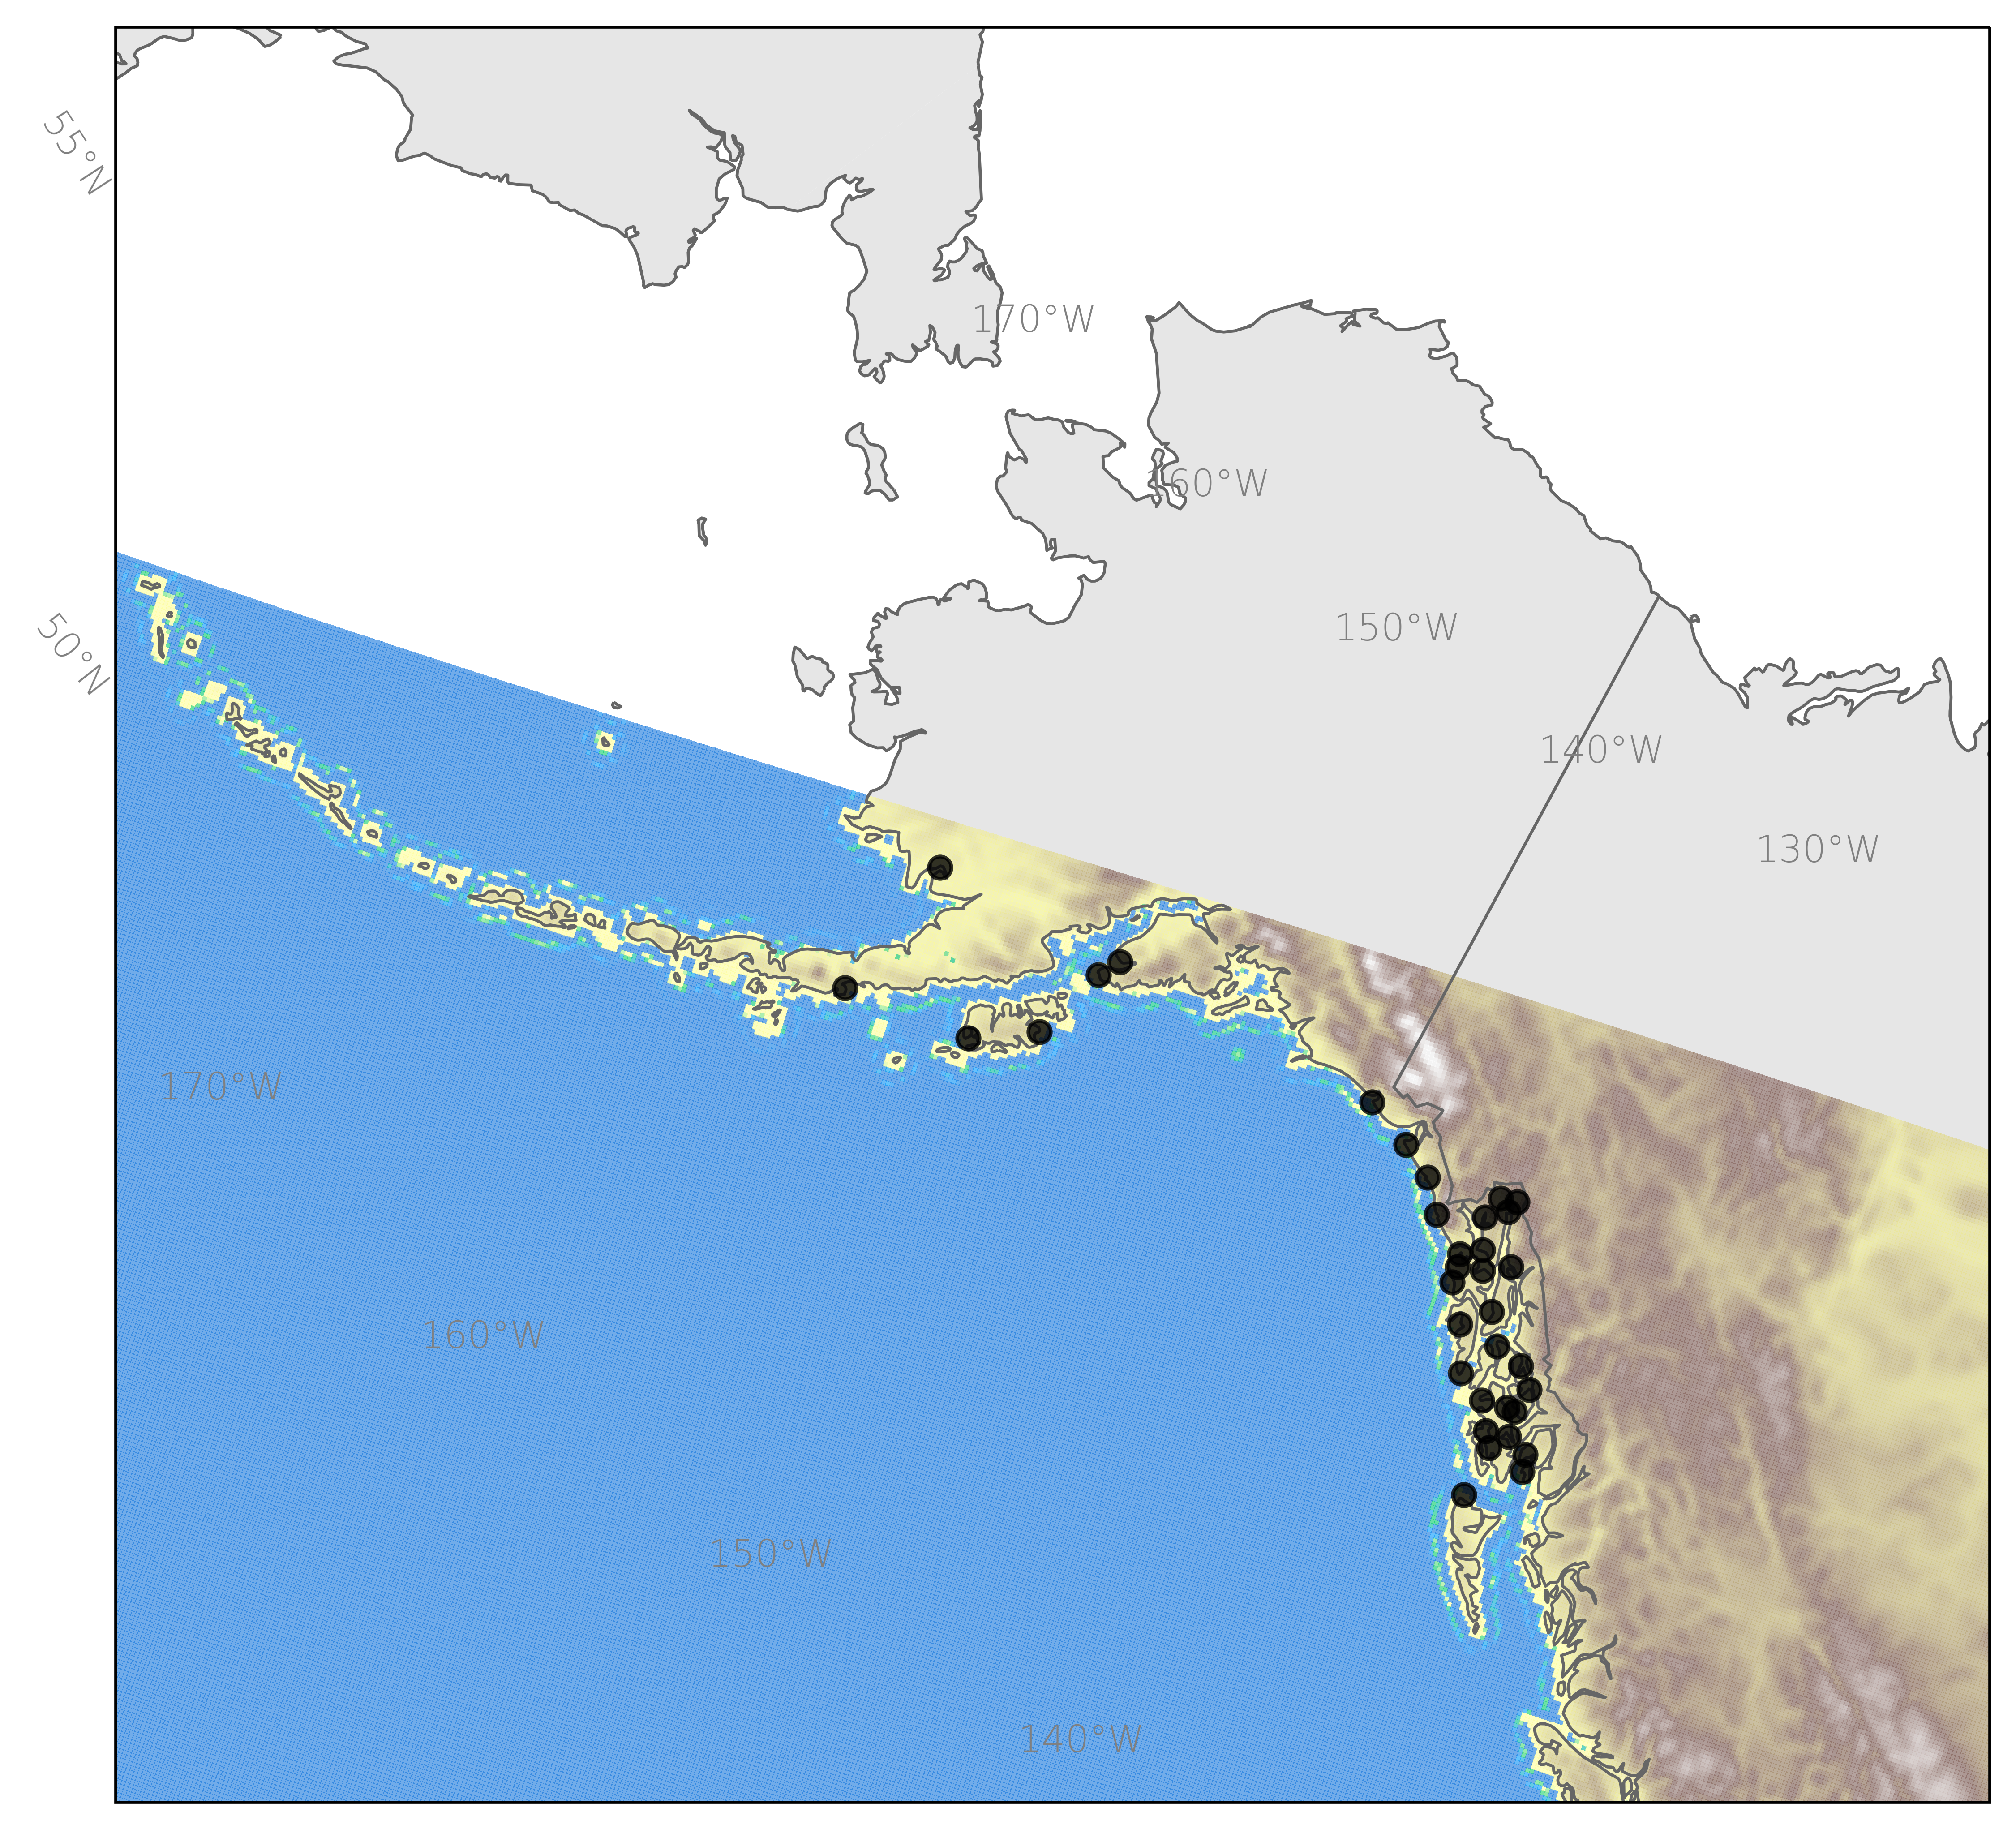

In [8]:
fig = plt.figure(figsize=(9.0 ,9.0))
fig.dpi = 600
fname = path_to_figs + 'AK_map_ARtools'
fmt1 = 'svg'
fmt2='png'

ax = plt.axes(projection=mapcrs)
ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy,left_lats=True, right_lats=False)

cf = ax.pcolormesh(lons, lats, elev, rasterized=True, norm=divnorm, 
                   cmap='terrain', shading='auto', transform=datacrs, alpha=0.6)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)

## Add different points
x = df['longitude'].values*-1
y = df['latitude'].values
ax.plot(x, y, 'ko', markersize=6, transform=datacrs, alpha=0.8)


fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi, transparent=True)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [9]:
## write to csv
df.to_csv(path_to_out + 'AK_W-WRF_points.csv')